# eQTL Interactions

- Cell type interaction
- Proportion of T cell states (cytotoxic, naive)
- Age, sex, IFN signature

Last updated August 2023

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(ggpubr)
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(vcfR)
    library(lme4)
    library(Matrix.utils)
    library(singlecellmethods)
    library(MASS)
    library(glmnet)
    library(patchwork)
    library(stringr)
    library(purrr)
    library(fitdistrplus)
    library(gridExtra)
    library(ggrastr)
    library(ggrepel)
    library(patchwork)
    library(viridis)
    require(gdata)
    library(readxl)
    library(coloc)
})

geno_df = readRDS('../data/sampleXdosage/four_cohorts_variant_info_final.rds')
geno_df$POS = as.numeric(geno_df$POS)

figures_dir = '../SuppFigs/'
source('../scripts/utils.R')

# Plot cell type dependent eQTLs

## Cell-type-dependent plots

In [2]:
multi_dataset_dir = './4_multidataset_eQTLs/'

# Multi dataset results
B_plasma_results = read.csv(paste0(multi_dataset_dir, 'B_plasma_pseudobulk_eQTLs.csv'))
B_plasma_results$gene = str_replace(B_plasma_results$gene, '\\.', '-')
Myeloid_results = read.csv(paste0(multi_dataset_dir, 'Myeloid_pseudobulk_eQTLs.csv'))
Myeloid_results$gene = str_replace(Myeloid_results$gene, '\\.', '-')
T_results = read.csv(paste0(multi_dataset_dir, 'T_pseudobulk_eQTLs.csv')) %>% mutate(cell_type = 'T')
T_results$gene = str_replace(T_results$gene, '\\.', '-')

B_plasma_sampleXdosage = readRDS(paste0(multi_dataset_dir, 'B_plasma_sampleXdosage.rds'))
B_plasma_residuals = readRDS(paste0(multi_dataset_dir, 'B_plasma_residuals.rds'))
colnames(B_plasma_residuals) = str_replace(colnames(B_plasma_residuals), '\\.', '-')
B_plasma_sampleXdosage = B_plasma_sampleXdosage %>% round() %>% as.data.frame()
B_plasma_data = cbind(B_plasma_residuals, B_plasma_sampleXdosage)
B_plasma_data$cell_type = 'B'

Myeloid_sampleXdosage = readRDS(paste0(multi_dataset_dir, 'Myeloid_sampleXdosage.rds'))
Myeloid_residuals = readRDS(paste0(multi_dataset_dir, 'Myeloid_residuals.rds'))
colnames(Myeloid_residuals) = str_replace(colnames(Myeloid_residuals), '\\.', '-')
Myeloid_sampleXdosage = Myeloid_sampleXdosage %>% round() %>% as.data.frame()
Myeloid_data = cbind(Myeloid_residuals, Myeloid_sampleXdosage)
Myeloid_data$cell_type = 'Myeloid'

T_sampleXdosage = readRDS(paste0(multi_dataset_dir, 'T_sampleXdosage.rds'))
T_residuals = readRDS(paste0(multi_dataset_dir, 'T_residuals.rds'))
colnames(T_residuals) = str_replace(colnames(T_residuals), '\\.', '-')
T_sampleXdosage = T_sampleXdosage %>% round() %>% as.data.frame()
T_data = cbind(T_residuals, T_sampleXdosage)
T_data$cell_type = 'T'

results = read.csv('./5_multidataset_interaction/cell_type_interaction_lrt.csv')
results$X.1 = NULL
results$X = NULL
results$gene = str_replace(results$gene, '\\.', '-')
results$cell_type = ifelse(results$cell_type == 'TRUE', 'T', results$cell_type)

results$lead_eQTL_for = paste(results$cell_type, results$gene, sep = ' | ')
results = results %>% mutate(lead_eQTL_beta = beta, lead_eQTL_p.val = p.val) %>% arrange(lrt_pval) %>%
    mutate(bonf_p = p.adjust(lrt_pval, method = 'bonferroni'))
results %>% dplyr::select(variant, lead_eQTL_for, lead_eQTL_beta, lead_eQTL_p.val, lrt_pval, bonf_p)

variant,lead_eQTL_for,lead_eQTL_beta,lead_eQTL_p.val,lrt_pval,bonf_p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
rs9271117,B | HLA-DRB1,0.6980761,1.075935e-128,7.348347e-87,1.763603e-85
rs9271112,Myeloid | HLA-DRB1,0.2724705,3.957589e-22,4.037877e-86,9.690904e-85
rs2395305,B | HLA-DPB1,0.5474434,4.343055e-99,2.666156e-67,6.398774e-66
HLA_C_07,B | HLA-C,-0.8859126,2.872157e-210,7.075184e-52,1.698044e-50
rs2163472,B | HLA-DPA1,0.4320438,5.470229e-67,1.331798e-48,3.196316e-47
rs2524096,Myeloid | HLA-C,0.6461640,4.821300e-106,3.163973e-35,7.593534e-34
rs3828789,Myeloid | HLA-DQB1,-0.6889048,6.306445e-130,2.936857e-24,7.048458e-23
rs9272346,B | HLA-DQB1,-0.6376775,3.500971e-109,1.073172e-23,2.575613e-22
rs9271375,B | HLA-DQA1,0.4792688,4.856008e-58,1.928648e-23,4.628756e-22


In [3]:
eqtl_boxplot_by_cell_type = function(in.variant, in.gene, data, results, ylim_min = -2.5, ylim_max = 2.5) {
    # Residualize out dataset
    colnames(data) = str_replace(colnames(data), 'HLA-', 'HLA\\.')
    genedot = str_replace(in.gene, 'HLA-', 'HLA\\.')
    data$dataset = factor(data$dataset, levels = c('Randolph_NI', 'AMP2RA', 'OneK1K', 'Smillie')) # refactor to match model script
    mod = lm(as.formula(paste(genedot, ' ~ dataset + ', paste(in.variant, collapse = "+"), sep = "")), data = data)
    data[which(data$dataset == 'Smillie'), genedot] = data[which(data$dataset == 'Smillie'), genedot] - 
                                                           summary(mod)$coeff['datasetSmillie', 'Estimate']
    data[which(data$dataset == 'AMP2RA'), genedot] = data[which(data$dataset == 'AMP2RA'), genedot] - 
                                                           summary(mod)$coeff['datasetAMP2RA', 'Estimate']
    data[which(data$dataset == 'OneK1K'), genedot] = data[which(data$dataset == 'OneK1K'), genedot] - 
                                                           summary(mod)$coeff['datasetOneK1K', 'Estimate']
    data$dataset = revalue(data$dataset, old_new_dataset_names)
    data$dataset = factor(data$dataset, levels = c('Synovium', 'Intestine', 'PBMC-cultured', 'PBMC-blood'))
    colnames(data) = str_replace(colnames(data), 'HLA\\.', 'HLA-')
    
    # Plot eQTL
    data[, in.variant] = as.factor(data[, in.variant])
    pval = results[which(results$variant == in.variant & results$gene == in.gene), 'p.val'] %>% unlist()
    beta = results[which(results$variant == in.variant & results$gene == in.gene), 'beta'] %>% unlist()
    subtitle = paste0('p=', format(pval, digits = 3, scientific = TRUE),'; beta=', format(beta, digits = 2))
    
    fig.size(4, 4)
    myREF = geno_df[which(geno_df$ID == in.variant), 'REF']
    myALT = geno_df[which(geno_df$ID == in.variant), 'ALT']
    data[, in.variant] = plyr::mapvalues(data[, in.variant], c(0, 1, 2), 
                                      c(paste0(myREF, '/', myREF), paste0(myREF, '/', myALT), paste0(myALT, '/', myALT)), warn_missing = TRUE)
    
    variantn = in.variant
    # Add newlines at 4th "_"
    if (startsWith(variantn, 'SNPS')){
            str_vec <- strsplit(variantn, "_")[[1]] 
            where <- seq_along(str_vec) == 4
            str_vec[where] <- sub("", "\n", str_vec[where])
            variantn = paste(str_vec, collapse="_")
    }
    
    p = ggplot(data) +
        geom_boxplot(aes(x = get(in.variant), y = get(in.gene), fill = dataset, color = dataset), outlier.size = 0.2) +
        geom_point_rast(aes(x = get(in.variant), y = get(in.gene), fill = dataset), size = 0.2, alpha = 0.4, position=position_jitterdodge()) +
        theme_classic() + theme(legend.position = 'none') +
        ylab(paste(in.gene, 'residual')) + xlab(variantn) + ylim(ylim_min, ylim_max) +
        # add significance and beta
        labs(subtitle = subtitle) + scale_color_manual(values = cohort_colors_darker) + scale_fill_manual(values = cohort_colors)
    return(p)
}

In [4]:
eqtl_boxplots_by_cell_type = function(variant, gene, pad = 0.1) {
    # calculate y-axis limits to make them consistent across plots
    ylim_min = min(B_plasma_data[, gene], Myeloid_data[, gene], T_data[, gene]) - pad
    ylim_max = max(B_plasma_data[, gene], Myeloid_data[, gene], T_data[, gene]) + pad
    
    p1 = eqtl_boxplot_by_cell_type(variant, gene, B_plasma_data, B_plasma_results, ylim_min, ylim_max) + ggtitle('B')
    p2 = eqtl_boxplot_by_cell_type(variant, gene, Myeloid_data, Myeloid_results, ylim_min, ylim_max) + ggtitle('Myeloid')
    p3 = eqtl_boxplot_by_cell_type(variant, gene, T_data, T_results, ylim_min, ylim_max) + ggtitle('T') + theme(legend.position = 'right')
    
    fig.size(3, 9)
    (p1 | p2 | p3)
}

png 
  2

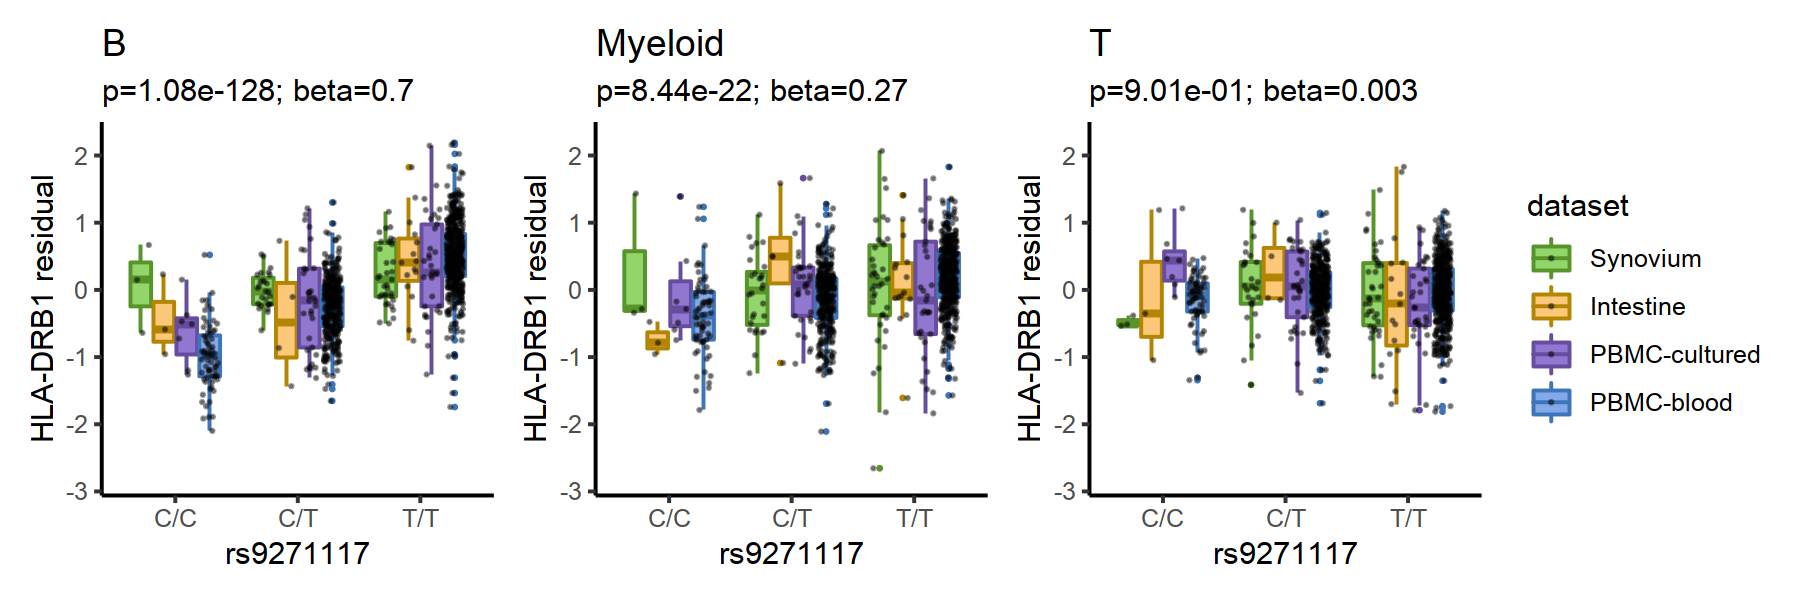

In [5]:
pdf(paste0(figures_dir, 'rs9271117_pseudobulk_celltype_interaction.pdf'), width = 10, height = 3.5)
fig.size(3.5, 10)
suppressMessages({
p = eqtl_boxplots_by_cell_type(results[1, 'variant'], results[1, 'gene']) })
print(p)
dev.off()
p

png 
  2

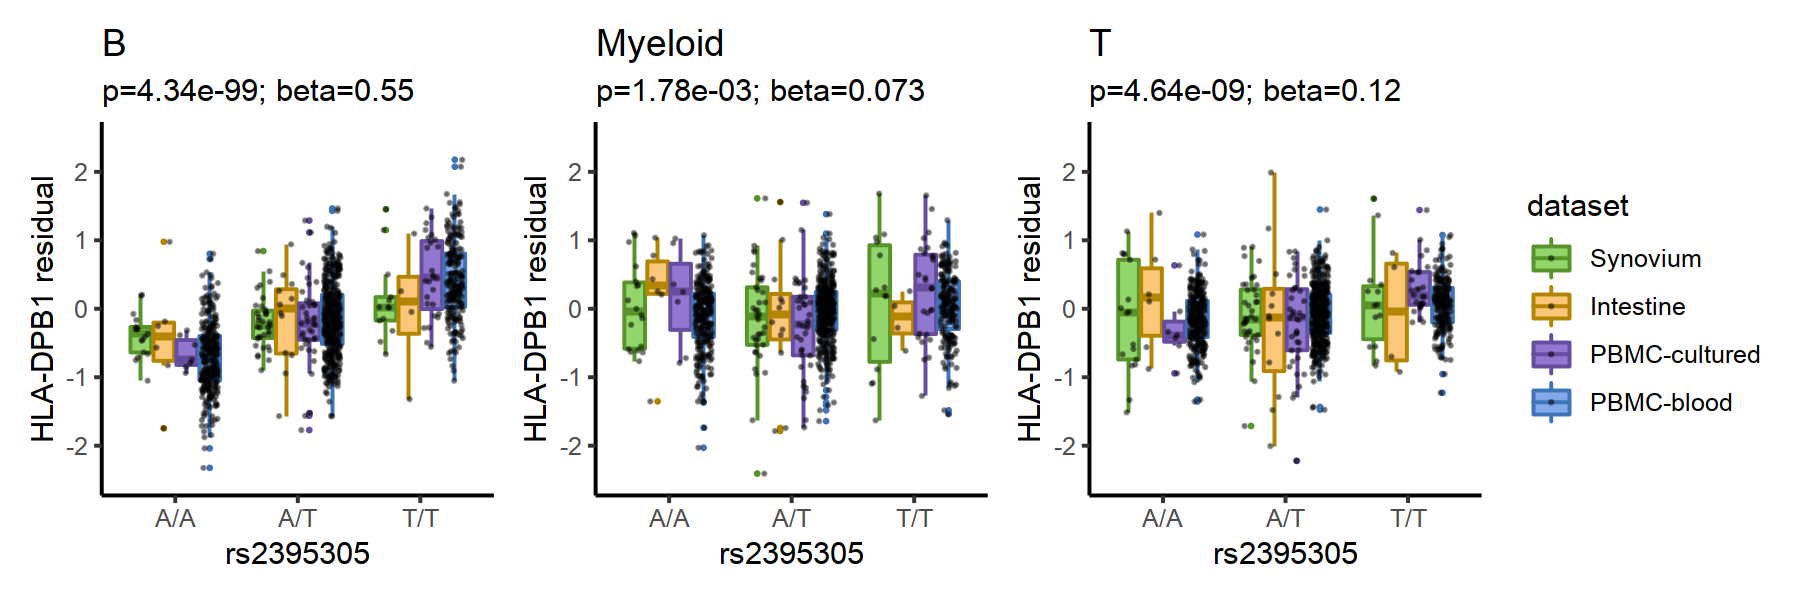

In [6]:
pdf(paste0(figures_dir, 'rs2395305_pseudobulk_celltype_interaction.pdf'), width = 10, height = 3.5)
fig.size(3.5, 10)
suppressMessages({
p = eqtl_boxplots_by_cell_type(results[3, 'variant'], results[3, 'gene']) })
print(p)
dev.off()
p

png 
  2

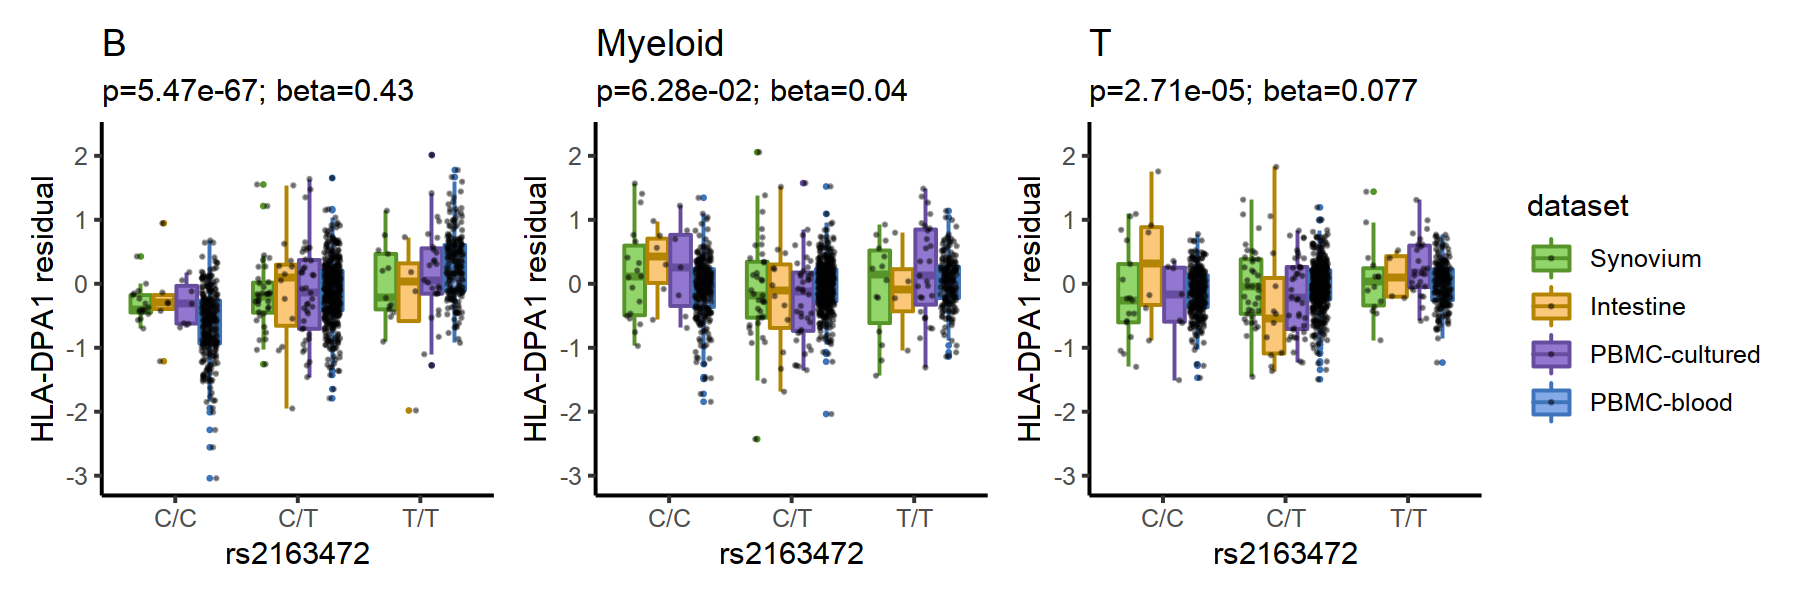

In [7]:
pdf(paste0(figures_dir, 'rs2163472_pseudobulk_celltype_interaction.pdf'), width = 10, height = 3.5)
fig.size(3.5, 10)
suppressMessages({
p = eqtl_boxplots_by_cell_type(results[5, 'variant'], results[5, 'gene'], pad = 0.2) })
print(p)
dev.off()
p

## Write supp table

In [8]:
results = results %>% dplyr::select(variant, cell_type, gene, lead_eQTL_for, beta, stderr, p.val, lrt_pval)

For every variant, add the beta and p.value in each cell type

In [9]:
results$Myeloid_beta = NA
results$Myeloid_p.val = NA
results$B_beta = NA
results$B_p.val = NA
results$T_beta = NA
results$T_p.val = NA
for (i in 1:nrow(results)) {
    mygene = results$gene[i]
    myvariant = results$variant[i]
    results$B_beta[i] = B_plasma_results$beta[which(B_plasma_results$gene == mygene & B_plasma_results$variant == myvariant)]
    results$B_p.val[i] = B_plasma_results$p.val[which(B_plasma_results$gene == mygene & B_plasma_results$variant == myvariant)]
    results$Myeloid_beta[i] = Myeloid_results$beta[which(Myeloid_results$gene == mygene & Myeloid_results$variant == myvariant)]
    results$Myeloid_p.val[i] = Myeloid_results$p.val[which(Myeloid_results$gene == mygene & Myeloid_results$variant == myvariant)]
    results$T_beta[i] = T_results$beta[which(T_results$gene == mygene & T_results$variant == myvariant)]
    results$T_p.val[i] = T_results$p.val[which(T_results$gene == mygene & T_results$variant == myvariant)]
}

In [10]:
write.csv(results, '/data/srlab1/jkang/hla2023/SuppTables/Table_cell_type_interaction.csv', row.names = F, quote = F)

# Plot age/sex dependent eQTLs - OneK1K

In [11]:
combined_result = NULL
for (c in c('B_plasma', 'Myeloid', 'T')) {
    lead_vars = read.csv(paste0('4_multidataset_eQTLs/', c, '_lead_variants.csv'), row.names = 1)
    for (i in 1:nrow(lead_vars)) {
        snp = lead_vars[i, 'variant']
        gene = str_replace(lead_vars[i, 'gene'], '-', '\\.')
        res = readRDS(paste0('./5_multidataset_interaction/', c, '_', gene, '_', snp,'_age_sex_int_OneK1K.rds'))
        
        res_to_add = data.frame(cell_type = c, gene = str_replace(gene, '\\.', '-'), variant = snp, 
                age_beta = round(res$age_int_mod$coefficients['Age'], 5),  # effect of age
                agexG_beta = round(res$age_int_mod$coefficients['Age:snp'], 5),  # effect of agexG
                agexG_lrt_pval = round(res$age_lrt_P, 5), # significance of agexG
                female_beta = round(res$sex_int_mod$coefficients['Female'], 5), # effect of sex
                femalexG_beta = round(res$sex_int_mod$coefficients['Female:snp'], 5), # effect of sexxG
                femalexG_lrt_pval = round(res$sex_lrt_P, 5)) %>%
                mutate(agexG_lrt_pval = as.numeric(format(agexG_lrt_pval, digits = 5, scientific = TRUE)),
                       femalexG_lrt_pval = as.numeric(format(femalexG_lrt_pval, digits = 5, scientific = TRUE)))
        combined_result = rbind(combined_result, res_to_add)
        rownames(combined_result) = NULL
    }
}

In [12]:
0.05 / 24 # Bonferroni

[1] 0.002083333

## Write supp table

In [13]:
combined_result
write.csv(combined_result, '../SuppTables/age_sex_interaction_OneK1K.csv', row.names = FALSE)

cell_type,gene,variant,age_beta,agexG_beta,agexG_lrt_pval,female_beta,femalexG_beta,femalexG_lrt_pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B_plasma,HLA-A,rs417162,-0.00042,-0.00002,0.98661,0.05311,-0.07749,0.06531
B_plasma,HLA-B,HLA_B_15,0.00040,-0.00291,0.25331,-0.05596,-0.01266,0.88479
B_plasma,HLA-C,HLA_C_07,-0.00100,0.00101,0.46503,-0.00760,-0.04170,0.34097
B_plasma,HLA-DPA1,rs2163472,-0.00487,0.00182,0.20142,-0.02168,0.05418,0.25341
B_plasma,HLA-DPB1,rs2395305,-0.00179,-0.00037,0.80133,-0.04676,0.06794,0.17181
B_plasma,HLA-DQA1,rs9271375,-0.00233,0.00084,0.63484,-0.06753,0.06626,0.26074
B_plasma,HLA-DQB1,rs9272346,-0.00420,0.00315,0.04522,0.12512,-0.07222,0.18273
B_plasma,HLA-DRB1,rs9271117,-0.00491,0.00195,0.19067,0.01215,-0.02180,0.67504
Myeloid,HLA-A,rs7747253,-0.00037,0.00050,0.74163,0.07894,-0.04470,0.36448


Nominally significant - T HLA-DQB1 and B HLA-DQB1. No nominally significant results for sex.

## T | HLA-DQB1 | Age

In [14]:
# Examine the one instance passing significance
snp = 'rs9272271'
gene = 'HLA.DQB1'
cell_type = 'T'
res = readRDS(paste0('./5_multidataset_interaction/', cell_type, '_', 
                     gene, '_', snp, '_age_sex_int_OneK1K.rds'))
res$age_lrt_P
res$age_int_mod$coefficients

[1] 0.002965725

(Intercept)           Age           snp        Female          gPC1 
 -0.050311302   0.005977940  -0.240522755   0.070656324 -18.852133768 
         gPC2          gPC3          gPC4          gPC5       Age:snp 
-43.834484318   2.169346120   4.156712878  14.540531277  -0.006105524

In [15]:
res$data = res$data %>% mutate(Genotype = case_when(round(snp) == 0 ~ 'A/A',
                                                    round(snp) == 1 ~ 'A/T',
                                                    round(snp) == 2 ~ 'T/T'))

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



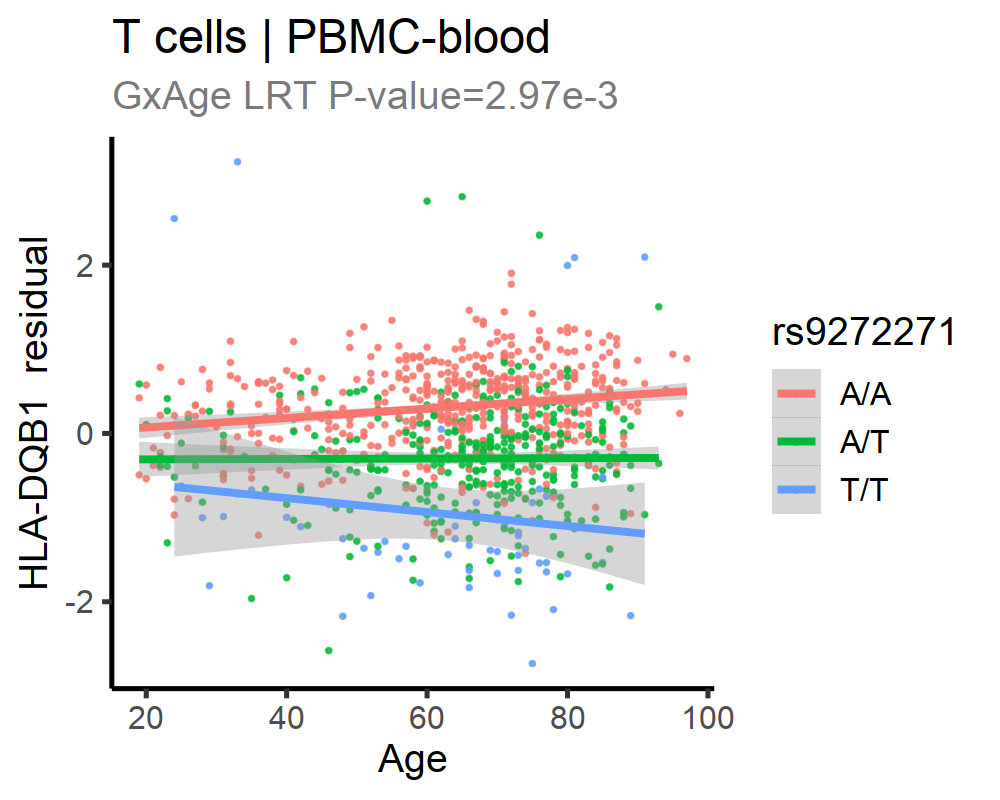

In [16]:
fig.size(4, 5)
pdf(paste0(figures_dir, 'T_HLA-DQB1_age_interaction_OneK1K.pdf'), width = 5, height = 4)
p = ggplot(res$data, aes(x = Age, y = exp_resid)) +
        geom_point_rast(aes(fill = Genotype, col = Genotype), size = 0.4, alpha = 0.8) +
        theme_classic(base_size = 14) + 
        ylab(paste(str_replace(gene, '\\.', '-'), ' residual')) + xlab('Age') + 
        theme(plot.subtitle=element_text(color = "grey48")) +
        geom_smooth(method = "lm", aes(col = Genotype)) + labs(fill = snp, col = snp) + 
        ggtitle('T cells | PBMC-blood', subtitle = 'GxAge LRT P-value=2.97e-3')
print(p)
dev.off()
p

## B | HLA-DQB1 | Age

In [17]:
# Examine the one instance passing significance
snp = 'rs9272346'
gene = 'HLA.DQB1'
cell_type = 'B_plasma'
res = readRDS(paste0('./5_multidataset_interaction/', cell_type, '_', 
                     gene, '_', snp, '_age_sex_int_OneK1K.rds'))
res$age_lrt_P
res$age_int_mod$coefficients

[1] 0.04521782

(Intercept)           Age           snp        Female          gPC1 
  1.482071064  -0.004202964  -0.847685973   0.041805930 -76.806869087 
         gPC2          gPC3          gPC4          gPC5       Age:snp 
-22.975512493   0.028205691   6.391820107   4.282389140   0.003148893

In [18]:
res$data = res$data %>% mutate(Genotype = case_when(round(snp) == 0 ~ 'G/G',
                                                    round(snp) == 1 ~ 'G/A',
                                                    round(snp) == 2 ~ 'A/A'))

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



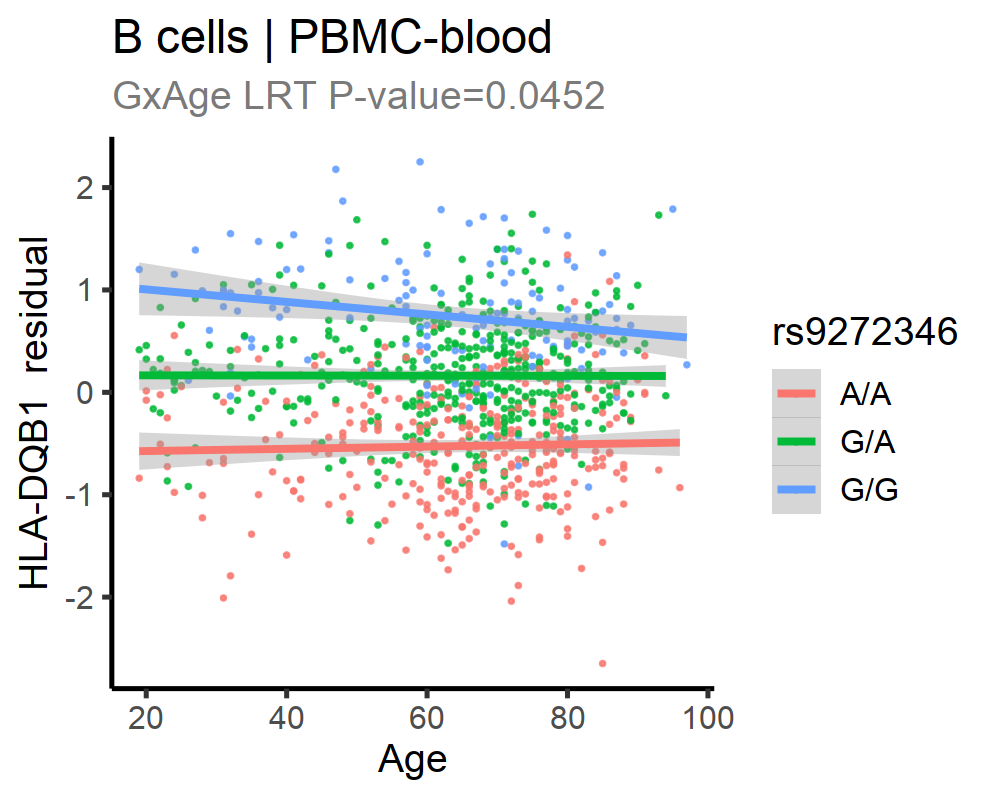

In [19]:
fig.size(4, 5)
pdf(paste0(figures_dir, 'B_HLA-DQB1_age_interaction_OneK1K.pdf'), width = 5, height = 4)
p = ggplot(res$data, aes(x = Age, y = exp_resid)) +
        geom_point_rast(aes(fill = Genotype, col = Genotype), size = 0.4, alpha = 0.8) +
        theme_classic(base_size = 14) + 
        ylab(paste(str_replace(gene, '\\.', '-'), ' residual')) + xlab('Age') + 
        theme(plot.subtitle=element_text(color = "grey48")) +
        geom_smooth(method = "lm", aes(col = Genotype)) + labs(fill = snp, col = snp) + 
        ggtitle('B cells | PBMC-blood', subtitle = 'GxAge LRT P-value=0.0452')
print(p)
dev.off()
p

## T cells - Calculate proportion of cell clusters per sample

In [20]:
ref_query = readRDS('../symphony/RefQuery_T_mapBloodOntoTissue.rds')
data_subset = cbind(ref_query$meta_data, ref_query$umap$embedding) %>% filter(dataset %in% c('OneK1K', 'AMP2RA'))
data_subset$dataset_cell_type_fine = revalue(data_subset$dataset_cell_type_fine, old_new_T)

sample_meta_AMP = read.csv('../data/meta//sample_meta_AMP2RA_completeHLA.csv')
sample_meta_OneK1K = read.csv('../data/meta//sample_meta_OneK1K_completeHLA.csv')
sample_meta = rbind(sample_meta_AMP[, c('Sample', 'Age', 'Female', 'Dataset')], 
                    sample_meta_OneK1K[, c('Sample', 'Age', 'Female', 'Dataset')])

data_subset = left_join(data_subset, sample_meta)

result <- data_subset %>%
  group_by(Sample) %>%
  dplyr::summarize(n = n()) %>% ungroup()

unique(data_subset$dataset_cell_type_fine)

Joining, by = "Sample"


[1] "CD4+ Memory"    "Treg"           "gdT"            "CD8+ Memory"   
 [5] "CD4+ Cytotoxic" "CD4+ Naive"     "Tph/Tfh"        "CD8+ Naive"    
 [9] "Proliferating"  "CD8+ Cytotoxic" "MT-high"        "dnT"

In [21]:
# Calculate proportion of cytotoxic cells
cytotoxic_states = c('CD4+ Cytotoxic', 'CD8+ Cytotoxic', 'gdT')

result$prop_cytotoxic = 0
for(i in 1:nrow(result)) {
    data_subset_sample = data_subset %>% filter(Sample == unlist(result[i, 'Sample']))
    n_cytotoxic_cells = sum((data_subset_sample$dataset_cell_type_fine %in% cytotoxic_states))
    result$prop_cytotoxic[i] = n_cytotoxic_cells / unlist(result[i, 'n'])
}

# Calculate proportion of naive cells
naive_states = c('CD4+ Naive', 'CD8+ Naive')

result$prop_naive = 0
for(i in 1:nrow(result)) {
    data_subset_sample = data_subset %>% filter(Sample == unlist(result[i, 'Sample']))
    n_naive_cells = sum((data_subset_sample$dataset_cell_type_fine %in% naive_states))
    result$prop_naive[i] = n_naive_cells / unlist(result[i, 'n'])
}

In [22]:
result = left_join(result, sample_meta)
result %>% head(4)

Joining, by = "Sample"


Sample,n,prop_cytotoxic,prop_naive,Age,Female,Dataset
<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>
1_1,582,0.3848797,0.1580756,65,1,OneK1K
10_10,429,0.1445221,0.2680653,78,1,OneK1K
1000_1001,721,0.1054092,0.1220527,73,1,OneK1K
1001_1002,835,0.1461078,0.2011976,57,1,OneK1K


In [23]:
result_OneK1K = result %>% filter(Dataset == 'OneK1K')
cor.test(result_OneK1K$Age, result_OneK1K$prop_cytotoxic)
cor.test(result_OneK1K$Age, result_OneK1K$prop_naive)


	Pearson's product-moment correlation

data:  result_OneK1K$Age and result_OneK1K$prop_cytotoxic
t = 8.8944, df = 907, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2223097 0.3419645
sample estimates:
      cor 
0.2832389 



	Pearson's product-moment correlation

data:  result_OneK1K$Age and result_OneK1K$prop_naive
t = -18.992, df = 907, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5783735 -0.4852161
sample estimates:
       cor 
-0.5334104 


Age is positively correlated with the proportion of cytotoxic T cells

png 
  2

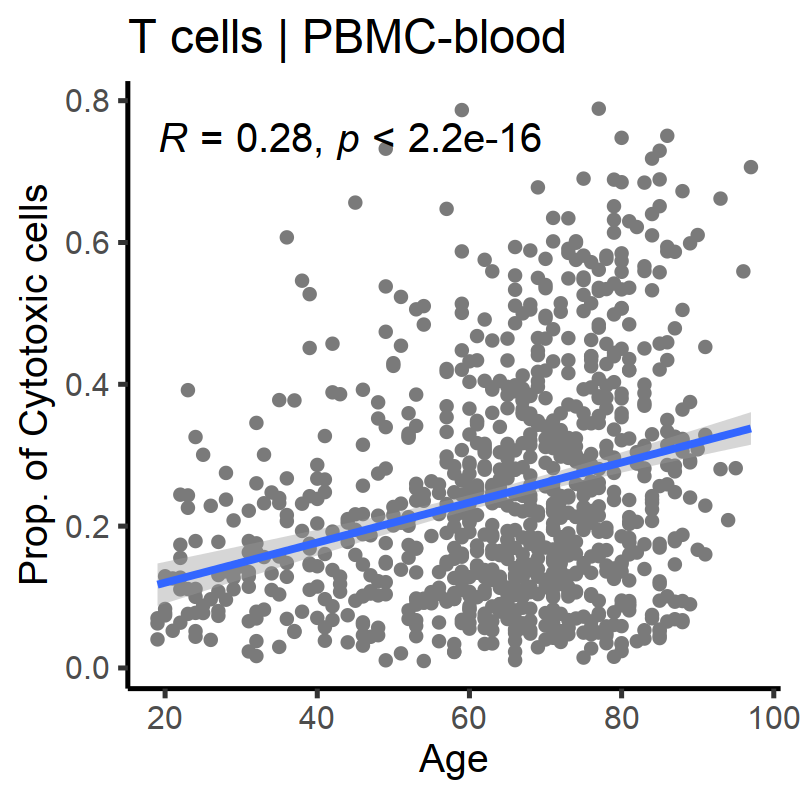

In [24]:
df = cbind(result_OneK1K$Age, result_OneK1K$prop_cytotoxic) %>% as.data.frame()
colnames(df) = c('Age', 'Prop_cytotoxic')

fig.size(4, 4)
pdf(paste0(figures_dir, 'T_Age_vs_PropCytotoxic_OneK1K.pdf'), width = 4, height = 4)
p = df %>% ggplot(aes(x = Age, y = Prop_cytotoxic)) +
            geom_point(col = 'grey48') +
            stat_cor(size = 5) + theme_classic(base_size = 14) + 
            ylab('Prop. of Cytotoxic cells') +
            ggtitle('T cells | PBMC-blood') +
            stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")
print(p)
dev.off()
p

Age is negatively correlated with the proportion of naive T cells.

png 
  2

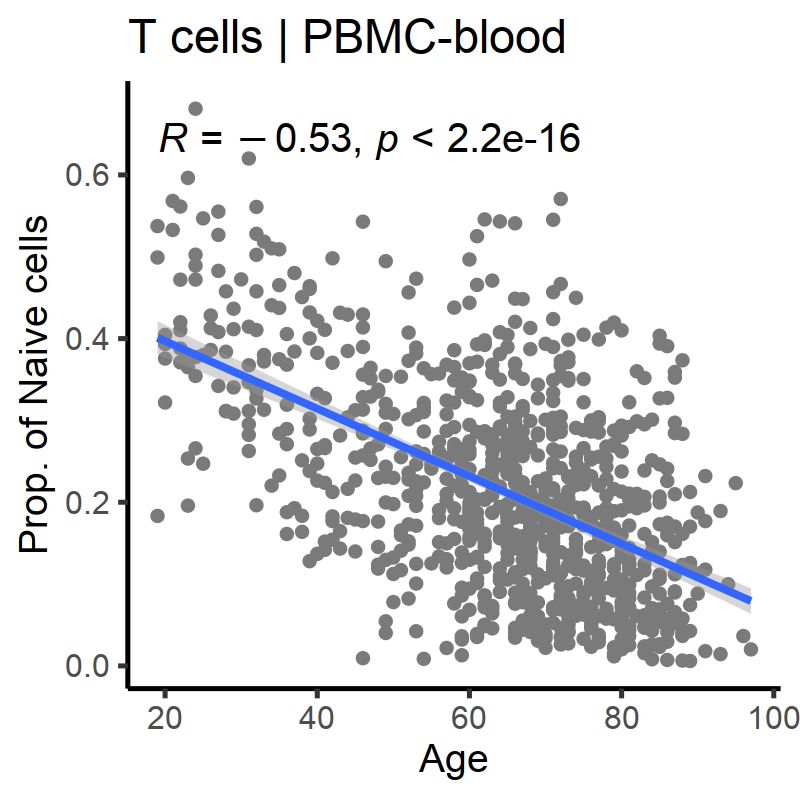

In [25]:
df = cbind(result_OneK1K$Age, result_OneK1K$prop_naive) %>% as.data.frame()
colnames(df) = c('Age', 'Prop_naive')

fig.size(4, 4)
pdf(paste0(figures_dir, 'T_Age_vs_PropNaive_OneK1K.pdf'), width = 4, height = 4)
p = df %>% ggplot(aes(x = Age, y = Prop_naive)) +
            geom_point(col = 'grey48') +
            stat_cor(size = 5) + theme_classic(base_size = 14) + 
            ylab('Prop. of Naive cells') +
            ggtitle('T cells | PBMC-blood') +
            stat_smooth(method = "lm", formula = y ~ x, geom = "smooth")
print(p)
dev.off()
p

In [26]:
saveRDS(result, './5_multidataset_interaction/T_cell_prop_cell_clusters.rds')

# Plot eQTL interactions with proportion of T cell clusters

In [27]:
combined_result = NULL
c = 'T'
lead_vars = read.csv(paste0('4_multidataset_eQTLs/', c, '_lead_variants.csv'), row.names = 1)
for (i in 1:nrow(lead_vars)) {
    snp = lead_vars[i, 'variant']
    gene = str_replace(lead_vars[i, 'gene'], '-', '\\.')
    res = readRDS(paste0('./5_multidataset_interaction/', c, '_', gene, '_', snp,'_T_cell_cluster_int.rds'))
    
    res_to_add = data.frame(cell_type = c, gene = str_replace(gene, '\\.', '-'), variant = snp, 
            prop_cytotoxic_beta = round(res$Cytotoxic_int_mod$coefficients['prop_cytotoxic'], 5), 
            prop_cytotoxicxG_beta = round(res$Cytotoxic_int_mod$coefficients[paste0('prop_cytotoxic:', snp)], 5),
            prop_cytotoxicxG_lrt_pval = round(res$Cytotoxic_lrt_P, 5), # significance of interaction
            
            prop_naive_beta = round(res$Naive_int_mod$coefficients['prop_naive'], 5), 
            prop_naivexG_beta = round(res$Naive_int_mod$coefficients[paste0('prop_naive:', snp)], 5),
            prop_naivexG_lrt_pval = round(res$Naive_lrt_P, 5))                                                              
    combined_result = rbind(combined_result, res_to_add)
    rownames(combined_result) = NULL
}

In [28]:
combined_result
## Save to table
write.csv(combined_result, '../SuppTables/OneK1K_T_cell_pseudobulk_int_prop_cell_state.csv', row.names = F)

cell_type,gene,variant,prop_cytotoxic_beta,prop_cytotoxicxG_beta,prop_cytotoxicxG_lrt_pval,prop_naive_beta,prop_naivexG_beta,prop_naivexG_lrt_pval
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T,HLA-A,rs7747253,0.01366,-0.00775,0.92750,0.01757,-0.03140,0.77872
T,HLA-B,HLA_B_15,0.19664,-0.49213,0.02402,-0.13809,0.47868,0.11844
T,HLA-C,rs2395471,-0.04385,-0.01796,0.87841,0.07133,-0.05424,0.72117
T,HLA-DPA1,HLA_DPB1_04.02,-0.03238,0.22455,0.21404,0.02741,-0.05056,0.82640
T,HLA-DPB1,rs1431403,-0.03258,0.05053,0.68210,0.13059,-0.07839,0.61436
T,HLA-DQA1,rs3104371,-0.38400,0.62838,0.00096,0.24546,-0.74192,0.00224
T,HLA-DQB1,rs9272271,-0.07648,-0.07030,0.74696,-0.59597,0.70392,0.00847
T,HLA-DRB1,rs17205184,-0.07124,0.16266,0.30159,0.08832,-0.05574,0.78063


`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



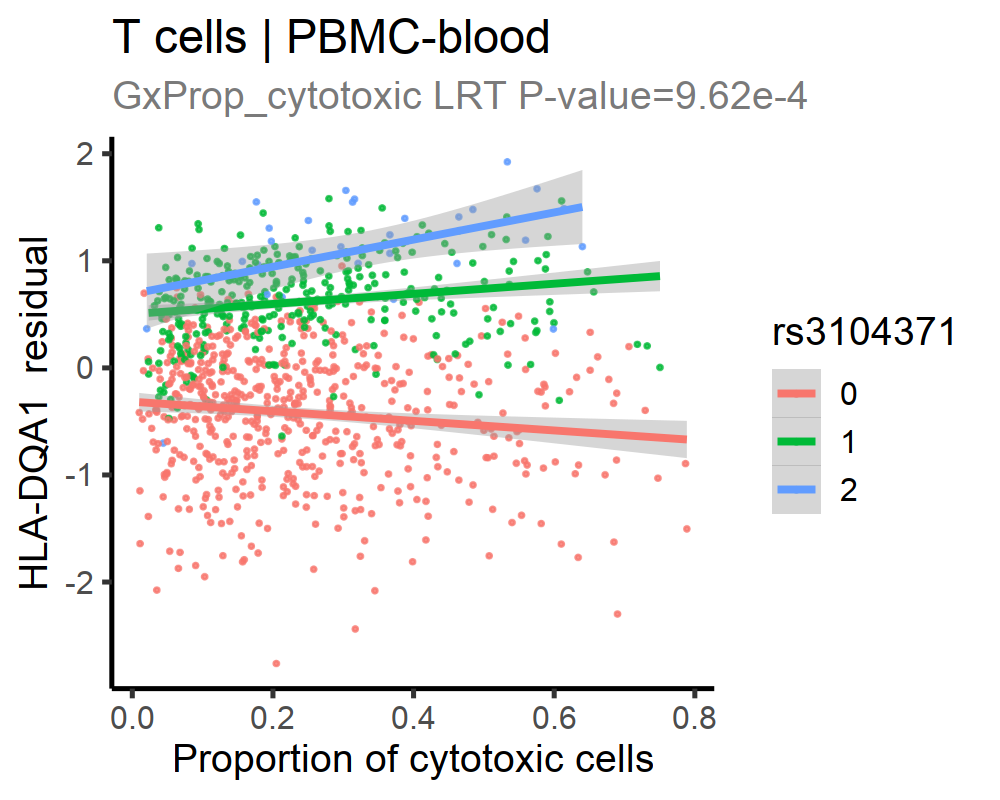

In [29]:
res = readRDS(paste0('./5_multidataset_interaction/T_HLA.DQA1_rs3104371_T_cell_cluster_int.rds'))
gene = 'HLA.DQA1'
res$data$rs3104371 = factor(round(res$data$rs3104371))

fig.size(4, 5)
pdf(paste0(figures_dir, 'T_HLA-DQA1_prop_cytotoxic_interaction_OneK1K.pdf'), width = 5, height = 4)
p = res$data %>%
    ggplot(aes(x = prop_cytotoxic, y = HLA.DQA1)) +
        geom_point_rast(aes(fill = rs3104371, col = rs3104371), size = 0.4, alpha = 0.8) +
        theme_classic(base_size = 14) + 
        ylab(paste(str_replace(gene, '\\.', '-'), ' residual')) + xlab('Proportion of cytotoxic cells') + 
        theme(plot.subtitle=element_text(color = "grey48")) +
        geom_smooth(method = "lm", aes(col = rs3104371)) + labs(fill = 'rs3104371', col = 'rs3104371') + 
        ggtitle('T cells | PBMC-blood', subtitle = 'GxProp_cytotoxic LRT P-value=9.62e-4')
print(p)
dev.off()
p

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



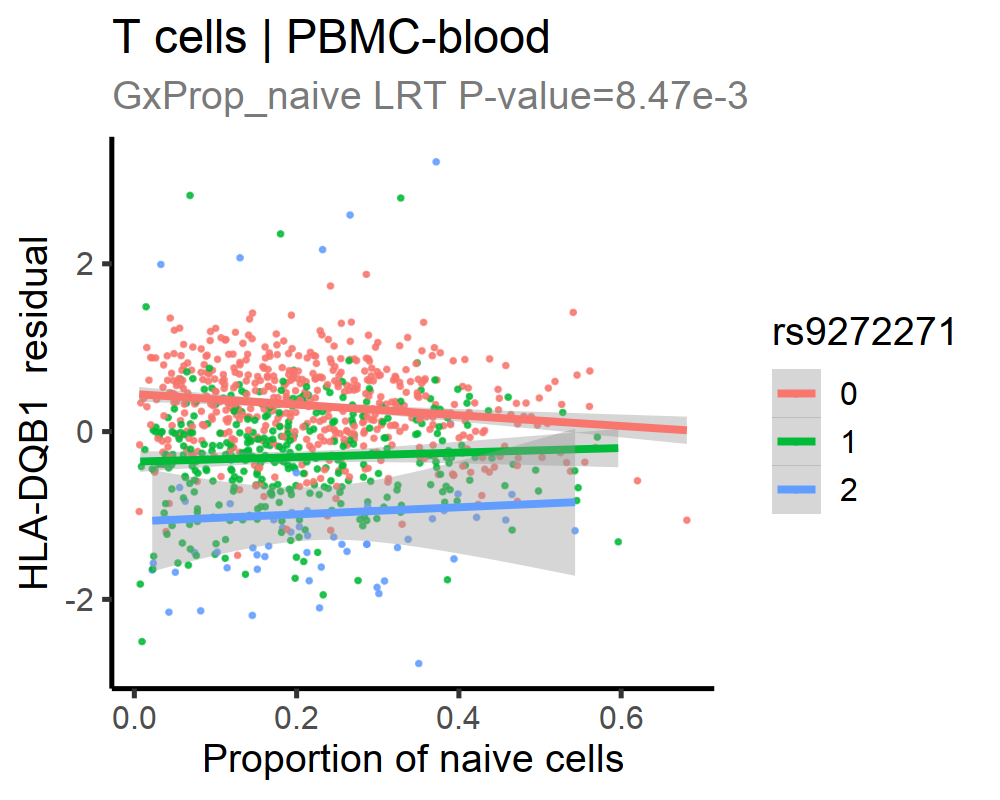

In [30]:
res = readRDS(paste0('./5_multidataset_interaction/T_HLA.DQB1_rs9272271_T_cell_cluster_int.rds'))
gene = 'HLA.DQB1'
res$data$rs9272271 = factor(round(res$data$rs9272271))

fig.size(4, 5)
pdf(paste0(figures_dir, 'T_HLA-DQB1_prop_naive_interaction_OneK1K.pdf'), width = 5, height = 4)
p = res$data %>%
    ggplot(aes(x = prop_naive, y = HLA.DQB1)) +
        geom_point_rast(aes(fill = rs9272271, col = rs9272271), size = 0.4, alpha = 0.8) +
        theme_classic(base_size = 14) + 
        ylab(paste(str_replace(gene, '\\.', '-'), ' residual')) + xlab('Proportion of naive cells') + 
        theme(plot.subtitle=element_text(color = "grey48")) +
        geom_smooth(method = "lm", aes(col = rs9272271)) + labs(fill = 'rs9272271', col = 'rs9272271') + 
        ggtitle('T cells | PBMC-blood', subtitle = 'GxProp_naive LRT P-value=8.47e-3')
print(p)
dev.off()
p

# Plot IFN score (Davenport et al.) dependent eQTLs

In [31]:
combined_result = NULL
d = 'OneK1K'
for (c in c('B_plasma', 'Myeloid', 'T')) {
    lead_vars = read.csv(paste0('4_multidataset_eQTLs/', c, '_lead_variants.csv'), row.names = 1)
    for (i in 1:nrow(lead_vars)) {
        snp = lead_vars[i, 'variant']
        gene = str_replace(lead_vars[i, 'gene'], '-', '\\.')
        res = readRDS(paste0('./5_multidataset_interaction/', c, '_', gene, '_', 
                             snp, '_', d,'_IFN_score_Davenport_int.rds'))
        
        res_to_add = data.frame(cell_type = c, 
                                gene = str_replace(gene, '\\.', '-'), 
                                variant = snp, 
                                dataset = d,
                G_beta = round(res$IFN_score_int_mod$coefficients[snp], 5),
                IFN_score_beta = round(res$IFN_score_int_mod$coefficients['IFN_score'], 5), 
                IFN_scorexG_beta = round(res$IFN_score_int_mod$coefficients[paste0('IFN_score:', snp)], 5),
                IFN_score_LRT_p = round(res$IFN_score_lrt_P, 5))                                                           
        combined_result = rbind(combined_result, res_to_add)
        rownames(combined_result) = NULL
    }
}
combined_result %>% arrange(IFN_score_LRT_p) %>% filter(IFN_score_LRT_p < 0.1)

cell_type,gene,variant,dataset,G_beta,IFN_score_beta,IFN_scorexG_beta,IFN_score_LRT_p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B_plasma,HLA-DPA1,rs2163472,OneK1K,0.47123,0.06913,-0.06707,0.00661
B_plasma,HLA-B,HLA_B_15,OneK1K,-1.23683,0.05049,0.09107,0.01429
T,HLA-DPA1,HLA_DPB1_04.02,OneK1K,-0.27490,0.00843,-0.07618,0.04020
B_plasma,HLA-DRB1,rs9271117,OneK1K,0.75386,-0.08370,0.05532,0.04377
T,HLA-C,rs2395471,OneK1K,0.52739,0.02530,-0.03802,0.06089


## Write supp table

In [32]:
combined_result
write.csv(combined_result, '../SuppTables/IFN_interaction_Davenport_OneK1K.csv', row.names = FALSE)

cell_type,gene,variant,dataset,G_beta,IFN_score_beta,IFN_scorexG_beta,IFN_score_LRT_p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B_plasma,HLA-A,rs417162,OneK1K,0.57719,0.04989,0.01134,0.59617
B_plasma,HLA-B,HLA_B_15,OneK1K,-1.23683,0.05049,0.09107,0.01429
B_plasma,HLA-C,HLA_C_07,OneK1K,-0.86827,0.04231,0.00942,0.63453
B_plasma,HLA-DPA1,rs2163472,OneK1K,0.47123,0.06913,-0.06707,0.00661
B_plasma,HLA-DPB1,rs2395305,OneK1K,0.56930,-0.00543,0.00276,0.91493
B_plasma,HLA-DQA1,rs9271375,OneK1K,0.56281,-0.02827,0.02375,0.41499
B_plasma,HLA-DQB1,rs9272346,OneK1K,-0.65199,0.04073,-0.03814,0.22311
B_plasma,HLA-DRB1,rs9271117,OneK1K,0.75386,-0.08370,0.05532,0.04377
Myeloid,HLA-A,rs7747253,OneK1K,0.61948,0.05223,-0.01917,0.48170


Nominally significant - B HLA-DPA1, B HLA-B, B HLA-DRB1, T DPA1.

## B | HLA-DPA1 | OneK1K

In [33]:
# Examine the one instance passing significance
snp = 'rs2163472'
gene = 'HLA.DPA1'
cell_type = 'B_plasma'
res = res = readRDS(paste0('./5_multidataset_interaction/', cell_type, '_', gene, '_', 
                             snp, '_', d,'_IFN_score_Davenport_int.rds'))
res$IFN_score_lrt_P
res$IFN_score_int_mod$coefficients

[1] 0.006613942

(Intercept)           IFN_score           rs2163472 IFN_score:rs2163472 
        -0.42030197          0.06913387          0.47123262         -0.06706503

In [34]:
res$data = res$data %>% mutate(Genotype = case_when(round(rs2163472) == 0 ~ 'C/C',
                                                    round(rs2163472) == 1 ~ 'C/T',
                                                    round(rs2163472) == 2 ~ 'T/T'))

`geom_smooth()` using formula 'y ~ x'



png 
  2

`geom_smooth()` using formula 'y ~ x'



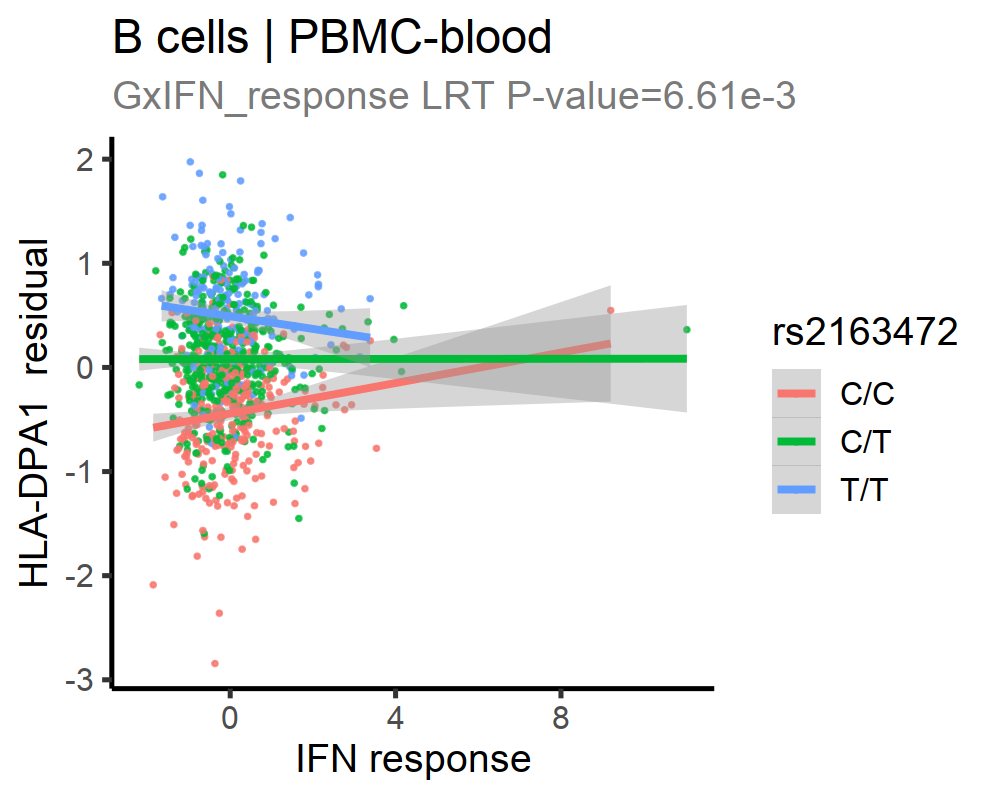

In [35]:
fig.size(4, 5)
pdf(paste0(figures_dir, 'B_plasma_HLA-DPA1_IFN_Davenport_interaction_OneK1K.pdf'), width = 5, height = 4)
p = ggplot(res$data, aes(x = IFN_score, y = HLA.DPA1)) +
        geom_point_rast(aes(fill = Genotype, col = Genotype), size = 0.4, alpha = 0.8) +
        theme_classic(base_size = 14) + 
        ylab(paste(str_replace(gene, '\\.', '-'), ' residual')) + xlab('IFN response') + 
        theme(plot.subtitle=element_text(color = "grey48")) +
        geom_smooth(method = "lm", aes(col = Genotype)) + labs(fill = snp, col = snp) + 
        ggtitle('B cells | PBMC-blood', subtitle = 'GxIFN_response LRT P-value=6.61e-3')
print(p)
dev.off()
p

- eQTL is weaker with higher IFN score
- plasmablasts have higher IFN score
- eQTL is weaker in plasmablasts

## Connect B cell states to IFN score

In [36]:
data = readRDS('../eqtl_single_cell/6_sceQTL_IFN_Sig_Davenport/OneK1K_IFN_Sig_NBME_data_IFN_B_plasma_HLA-DPA1_rs2163472.rds')
mean_score = data %>% dplyr::group_by(IND) %>% dplyr::summarise(mean_IFN_score = mean(IFN_score))
colnames(mean_score)[1] = 'Sample'
a = left_join(res$data, mean_score)
cor.test(a$mean_IFN_score, a$IFN_score)

Joining, by = "Sample"



	Pearson's product-moment correlation

data:  a$mean_IFN_score and a$IFN_score
t = 165.58, df = 907, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9816349 0.9858162
sample estimates:
      cor 
0.9838593 


In [37]:
md = readRDS('../symphony/OneK1K_B_plasma_batch2_reference.rds')$meta_data[, 
                                            c('cell_type_fine', 'cell_type_major')]

md$dataset_cell_type_fine = paste0('OneK1K_', md$cell_type_fine)
md$dataset_cell_type_fine = revalue(md$dataset_cell_type_fine, old_new_B_plasma)
md = cbind(md, data)
md %>% group_by(dataset_cell_type_fine) %>% dplyr::summarize(mean_IFN = mean(IFN_score),
                                                            p25 = quantile(IFN_score, 0.25),
                                                            p75 = quantile(IFN_score, 0.75))

The following `from` values were not present in `x`: AMP2RA_B-2: IgM+IgD+TCL1A+ naive, AMP2RA_B-1: CD24++CD27+IgM+ unswitched memory, AMP2RA_B-0: CD24+CD27+CD11b+ switched memory, AMP2RA_B-8: IgG1+IgG3+ plasma, AMP2RA_B-7: HLA-DR+IgG+ plasmablast, AMP2RA_B-3: IgM+IgD+CD1c+ MZ-like, AMP2RA_B-5: CD11c+LAMP1+ ABC, AMP2RA_B-6: IgM+ plasma, AMP2RA_B-4: AICDA+BCL6+ GC-like



dataset_cell_type_fine,mean_IFN,p25,p75
<chr>,<dbl>,<dbl>,<dbl>
Intermediate,0.06947091,-0.7716258,0.4222156
Memory,0.04256871,-0.7716258,0.3887330
Naive,-0.09505862,-0.7716258,0.1661949
Plasmablast,0.61355044,-0.1618102,1.0645552


png 
  2

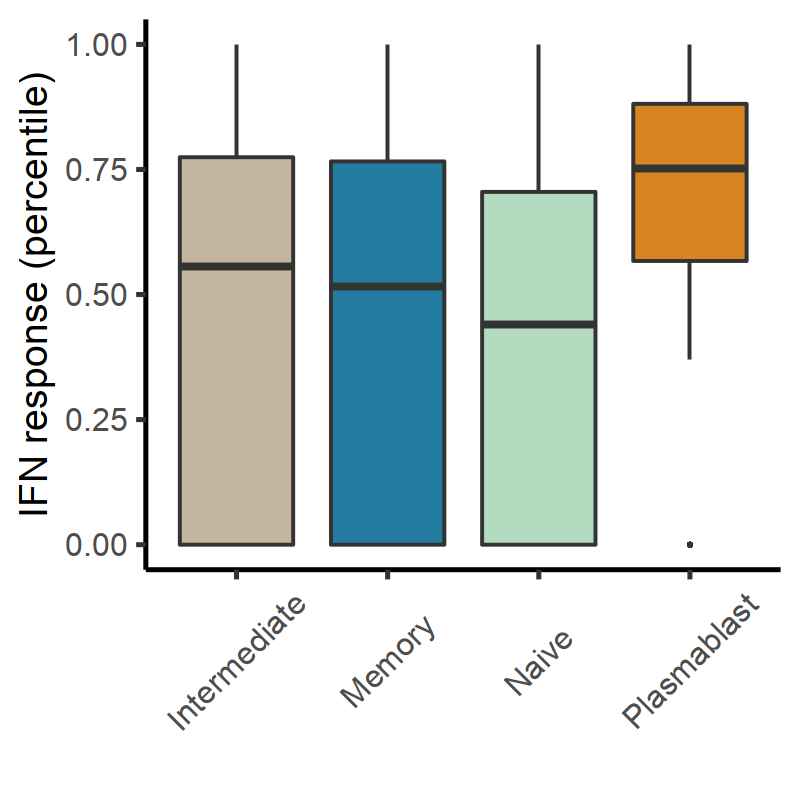

In [38]:
fig.size(4, 4)
pdf(paste0(figures_dir, 'B_plasma_IFN_Davenport_boxplot.pdf'), width = 4, height = 4)

p = md %>% ggplot(aes(x = dataset_cell_type_fine,
                      fill = dataset_cell_type_fine, 
                      y = percent_rank(IFN_score))) +
    #geom_violin() +
    geom_boxplot(outlier.size = 0.01) +
    xlab('') + ylab('IFN response (percentile)') + theme_classic(base_size = 14) +
    scale_fill_manual(values = B_plasma_colors) + theme(legend.position = 'none') +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))
print(p)
dev.off()
p

In [39]:
result = md %>%
  group_by(IND) %>%
  dplyr::summarize(n = n()) %>% ungroup()

unique(md$cell_type_fine)

[1] "B naive"        "B memory"       "B intermediate" "Plasmablast"

In [40]:
result$prop_plasma = 0
for(i in 1:nrow(result)) {
    md_sample = md %>% filter(IND == unlist(result[i, 'IND']))
    n_plasma_cells = sum((md_sample$cell_type_fine == 'Plasmablast'))
    result$prop_plasma[i] = n_plasma_cells / unlist(result[i, 'n'])
}
head(result)
colnames(result)[1] = 'Sample'

IND,n,prop_plasma
<fct>,<int>,<dbl>
1_1,106,0.00000000
10_10,60,0.00000000
1000_1001,100,0.03000000
1001_1002,91,0.01098901
1002_1003,76,0.06578947
1003_1004,113,0.02654867


In [41]:
x = left_join(res$data, result)
cor.test(x$prop_plasma, x$IFN_score)

Joining, by = "Sample"



	Pearson's product-moment correlation

data:  x$prop_plasma and x$IFN_score
t = 4.9403, df = 907, p-value = 9.286e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09788355 0.22453695
sample estimates:
      cor 
0.1618768 


# Done!

In [42]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] coloc_5.1.0.1           readxl_1.3.1            gdata_2.18.0           
 [4] viridis_0.6.2           viridisLite_0.4.1       ggrepel_0.9.1          
 [7] ggrastr_1.0.1           gridExtra_2.3           fitdistrplus_1.1-8     
[10] survival_3.3-1          purrr_